In [1]:
import os
import os.path
import glob
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Paired'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
imagedir = "CG_Resized"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [4]:
X.shape

(16396, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'cg_resized-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from cg_resized-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(16396, 2048)

In [9]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
top_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 169 candidates, totalling 845 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 43.6min


[CV] .............. C=0.01, gamma=1e-07, score=0.511890, total=23.7min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.511890, total=23.8min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.511890, total=23.8min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.511890, total=23.9min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.511890, total=23.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.511890, total=23.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.511890, total=23.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 48.3min


[CV] .............. C=0.01, gamma=1e-07, score=0.511890, total=26.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.511890, total=26.5min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.511890, total=26.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.511890, total=26.5min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.511890, total=26.5min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.511890, total=26.6min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.511890, total=26.6min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 49.1min


[CV] .............. C=0.01, gamma=0.001, score=0.885671, total=19.5min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.893902, total=19.6min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.901829, total=19.5min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.906707, total=19.5min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.900000, total=19.7min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.849085, total=23.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.861585, total=22.9min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 101.8min


[CV] ............... C=0.01, gamma=0.01, score=0.511890, total=29.5min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=0.01, score=0.511890, total=29.5min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=0.01, score=0.511890, total=29.7min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ................ C=0.01, gamma=0.1, score=0.511890, total=35.2min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ................ C=0.01, gamma=0.1, score=0.511890, total=35.7min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.511890, total=36.0min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.511890, total=36.0min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 133.4min


[CV] ................ C=0.01, gamma=1.0, score=0.511890, total=33.8min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.511890, total=33.6min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.511890, total=33.9min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.511890, total=34.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.511890, total=34.4min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.511890, total=34.4min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.511890, total=34.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 160.6min


[CV] ............. C=0.01, gamma=1000.0, score=0.511890, total=37.2min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.511890, total=37.6min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.511890, total=37.3min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.511890, total=37.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.511890, total=27.9min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.511890, total=27.8min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.511890, total=37.1min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 186.3min


[CV] .............. C=0.1, gamma=0.0001, score=0.916463, total=14.7min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.511890, total=26.1min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.511890, total=26.2min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.922561, total=14.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.511890, total=26.3min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.916159, total=14.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.511890, total=26.8min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 204.4min


[CV] ............... C=0.1, gamma=1e-05, score=0.854573, total=24.4min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.871341, total=24.6min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.511890, total=26.6min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.511890, total=26.9min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.511890, total=27.1min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................ C=0.1, gamma=0.01, score=0.511890, total=27.1min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ................ C=0.1, gamma=0.01, score=0.511890, total=27.2min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 269.9min


[CV] ................. C=0.1, gamma=1.0, score=0.511890, total=49.3min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.511890, total=48.4min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.511890, total=49.5min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.511890, total=48.7min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.511890, total=51.0min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.511890, total=51.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=100.0, score=0.511890, total=50.2min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 307.5min


[CV] .............. C=0.1, gamma=1000.0, score=0.511890, total=50.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-09, score=0.511890, total=26.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.511890, total=26.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.511890, total=24.9min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.511890, total=25.0min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.511890, total=25.0min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.511890, total=25.1min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 323.3min


[CV] ............... C=1.0, gamma=1e-07, score=0.511890, total=26.6min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.908841, total=13.1min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.964939, total= 7.0min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.962805, total= 6.9min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.964329, total= 6.9min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.915244, total=13.3min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.916463, total=13.4min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 402.3min


[CV] ............... C=1.0, gamma=100.0, score=0.516768, total=50.7min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.517683, total=62.4min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.519207, total=62.3min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.519512, total=62.8min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.519207, total=63.0min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.516768, total=58.8min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.518902, total=62.6min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 448.1min


[CV] .............. C=10.0, gamma=1e-09, score=0.511890, total=25.6min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.511890, total=24.8min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-09, score=0.511890, total=26.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.860671, total=23.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.511890, total=25.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.861890, total=23.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.850305, total=23.8min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 463.6min


[CV] .............. C=1.0, gamma=1000.0, score=0.516159, total=48.0min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.944207, total= 7.0min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.912805, total=13.8min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=1.0, gamma=1000.0, score=0.516463, total=48.4min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.968902, total= 7.7min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.967988, total= 7.2min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.964329, total= 7.8min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 582.0min


[CV] ............... C=10.0, gamma=0.1, score=0.519817, total=100.9min
[CV] C=100.0, gamma=1e-09 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.516768, total=93.8min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.517073, total=99.1min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=100.0, score=0.516768, total=87.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.516463, total=100.8min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=0.1, score=0.518902, total=105.4min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=10.0, score=0.516768, total=103.1min
[CV] C=100.0, gamma=1e-07 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 625.4min


[CV] ............. C=100.0, gamma=1e-09, score=0.511890, total=25.4min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-05, score=0.948171, total= 4.7min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.953659, total= 4.6min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.850305, total=23.7min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.860671, total=23.5min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.956098, total= 4.7min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.861890, total=23.4min
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 678.3min


[CV] ............ C=10.0, gamma=1000.0, score=0.516159, total=100.2min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............ C=10.0, gamma=1000.0, score=0.516768, total=102.3min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=10.0, gamma=100.0, score=0.516159, total=107.1min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=10.0, gamma=1000.0, score=0.516463, total=104.5min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=10.0, gamma=1000.0, score=0.516159, total=109.8min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.745122, total=79.7min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .............. C=100.0, gamma=0.01, score=0.757317, total=79.9min
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 781.6min


[CV] ............ C=1000.0, gamma=1e-08, score=0.914024, total=13.6min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.850000, total=22.7min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.918598, total=13.8min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.860976, total=22.8min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-09, score=0.861890, total=22.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.516768, total=90.1min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.912805, total=13.7min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 801.8min


[CV] ........... C=1000.0, gamma=0.0001, score=0.958841, total= 4.4min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............. C=100.0, gamma=100.0, score=0.516768, total=99.8min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............. C=100.0, gamma=10.0, score=0.516159, total=105.3min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.968902, total= 7.0min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.971951, total= 7.1min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.964329, total= 7.6min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ............ C=1000.0, gamma=0.001, score=0.967988, total= 7.7min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 927.5min


[CV] ............. C=1000.0, gamma=0.1, score=0.518293, total=105.7min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.936585, total= 6.8min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............ C=1000.0, gamma=10.0, score=0.516159, total=105.3min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ............. C=1000.0, gamma=1.0, score=0.516463, total=106.5min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.516768, total=85.4min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.908232, total=12.4min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.937805, total= 7.6min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 954.4min


[CV] ........... C=10000.0, gamma=1e-05, score=0.943293, total= 3.8min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=10000.0, gamma=1e-05, score=0.943902, total= 4.4min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.953354, total= 4.1min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.952134, total= 4.1min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.959451, total= 4.0min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.951220, total= 4.6min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .......... C=10000.0, gamma=0.0001, score=0.958841, total= 4.9min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 1078.9min


[CV] ............. C=10000.0, gamma=0.1, score=0.518902, total=95.4min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............ C=10000.0, gamma=10.0, score=0.516159, total=95.6min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............ C=10000.0, gamma=0.1, score=0.519512, total=100.9min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] ............ C=10000.0, gamma=10.0, score=0.516768, total=97.6min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=0.1, score=0.519817, total=106.6min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=0.1, score=0.519512, total=107.3min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=1.0, score=0.517073, total=100.8min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 1105.3min


[CV] .......... C=100000.0, gamma=1e-05, score=0.940854, total= 3.9min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.943293, total= 3.9min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.943598, total= 4.0min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.953354, total= 4.3min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.951220, total= 4.2min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.952134, total= 4.7min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=0.0001, score=0.959451, total= 4.7min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 1233.6min


[CV] ............ C=100000.0, gamma=0.1, score=0.519512, total=96.2min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.948476, total= 4.3min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=1.0, score=0.517073, total=100.4min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=0.1, score=0.518293, total=107.0min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.947256, total= 4.5min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ........... C=100000.0, gamma=1.0, score=0.517378, total=101.3min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ............ C=100000.0, gamma=1.0, score=0.517073, total=78.5min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 1269.2min


[CV] ........ C=1000000.0, gamma=0.0001, score=0.952134, total= 4.6min
[CV] C=1000000.0, gamma=0.001 ........................................
[CV] ........ C=1000000.0, gamma=0.0001, score=0.951220, total= 4.3min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=1000000.0, gamma=0.0001, score=0.959451, total= 4.5min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ........ C=1000000.0, gamma=0.0001, score=0.958841, total= 4.8min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=0.001, score=0.968902, total= 7.6min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=0.001, score=0.964329, total= 7.1min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=1000000.0, gamma=0.001, score=0.967988, total= 7.2min
[CV] C=1000000.0, gamma=0.1 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 1403.6min


[CV] ........ C=10000000.0, gamma=1e-09, score=0.945427, total= 3.7min
[CV] C=10000000.0, gamma=1e-09 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.943902, total= 4.0min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........... C=1000000.0, gamma=1.0, score=0.516463, total=96.7min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.949390, total= 3.9min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=0.1, score=0.519817, total=106.4min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=0.1, score=0.519512, total=105.8min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.950000, total= 4.0min
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 1429.8min


[CV] ....... C=10000000.0, gamma=0.0001, score=0.951220, total= 4.3min
[CV] C=10000000.0, gamma=0.01 ........................................
[CV] ....... C=10000000.0, gamma=0.0001, score=0.959451, total= 4.7min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=10000000.0, gamma=0.0001, score=0.958841, total= 4.9min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.967988, total= 7.3min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.968902, total= 7.9min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.971951, total= 7.3min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=10000000.0, gamma=0.001, score=0.964329, total= 7.8min
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 637 tasks      | elapsed: 1567.2min


[CV] ....... C=100000000.0, gamma=1e-09, score=0.950000, total= 4.4min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] .......... C=10000000.0, gamma=1.0, score=0.516463, total=97.6min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.931402, total= 5.7min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.928963, total= 6.3min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.927439, total= 5.9min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.930793, total= 7.4min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-07, score=0.924695, total= 4.0min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 1606.5min


[CV] ........ C=10000000.0, gamma=100.0, score=0.516768, total=83.8min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ........ C=10000000.0, gamma=10.0, score=0.516159, total=104.8min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ....... C=10000000.0, gamma=100.0, score=0.516159, total=105.8min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=10000000.0, gamma=100.0, score=0.516768, total=109.1min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=10000000.0, gamma=1000.0, score=0.516159, total=95.2min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=10000000.0, gamma=100.0, score=0.516463, total=108.9min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ....... C=10000000.0, gamma=1000.0, score=0.516768, total=98.9min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed: 1738.2min


[CV] ...... C=1000000000.0, gamma=1e-07, score=0.934451, total= 3.9min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-07, score=0.932622, total= 4.2min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.933841, total= 3.8min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.925000, total= 4.4min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.933537, total= 3.8min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.934146, total= 3.9min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.939024, total= 4.5min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 1848.6min


[CV] ....... C=1000000000.0, gamma=0.01, score=0.746037, total=82.1min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.01, score=0.757317, total=81.6min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.01, score=0.746037, total=82.4min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ........ C=1000000000.0, gamma=1.0, score=0.517073, total=78.4min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ........ C=1000000000.0, gamma=1.0, score=0.517073, total=90.7min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ........ C=1000000000.0, gamma=0.1, score=0.519817, total=96.7min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ........ C=1000000000.0, gamma=1.0, score=0.516768, total=92.1min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed: 1902.9min


[CV] .... C=10000000000.0, gamma=0.0001, score=0.953354, total= 4.3min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.959451, total= 4.2min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.951220, total= 4.3min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] .... C=10000000000.0, gamma=0.0001, score=0.958841, total= 4.8min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ....... C=1000000000.0, gamma=10.0, score=0.516768, total=84.7min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ...... C=1000000000.0, gamma=10.0, score=0.516463, total=106.3min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ..... C=10000000000.0, gamma=0.001, score=0.968902, total= 7.6min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed: 2099.1min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

In [10]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.001} - score: 0.9682


In [11]:
top_model.cv_results_

{'mean_fit_time': array([ 1243.75704913,  1234.54746733,  1237.20581365,  1158.00389438,
         1137.2175827 ,  1111.63295279,   944.02670407,  1420.01086063,
         1788.50317512,  1887.06323061,  1712.92161365,  1775.94014173,
         1902.61289325,  1323.01391163,  1301.87052646,  1270.86050034,
         1275.11366525,  1175.11101823,   708.54217305,   546.16148276,
         1288.76792536,  2545.13028417,  2676.78679814,  2651.98537259,
         2673.20297403,  2626.15768008,  1233.71483016,  1220.97510924,
         1251.63050981,  1147.32710533,   644.76199641,   362.60652399,
          336.10593886,  4006.70083618,  3438.84067364,  2818.30029616,
         2892.51924839,  2893.00515985,  2809.00999799,  1222.90101986,
         1230.2431726 ,  1125.29994483,   661.33037219,   343.20420384,
          230.42478075,   367.39490538,  4608.40678577,  5899.22431135,
         5424.96833291,  6002.36542068,  5822.5873332 ,  5748.6284276 ,
         1220.33488083,  1125.17503653,   655.8

In [12]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    ax.set_xscale('log')
    #ax.set_ylim([0.0,1.0])

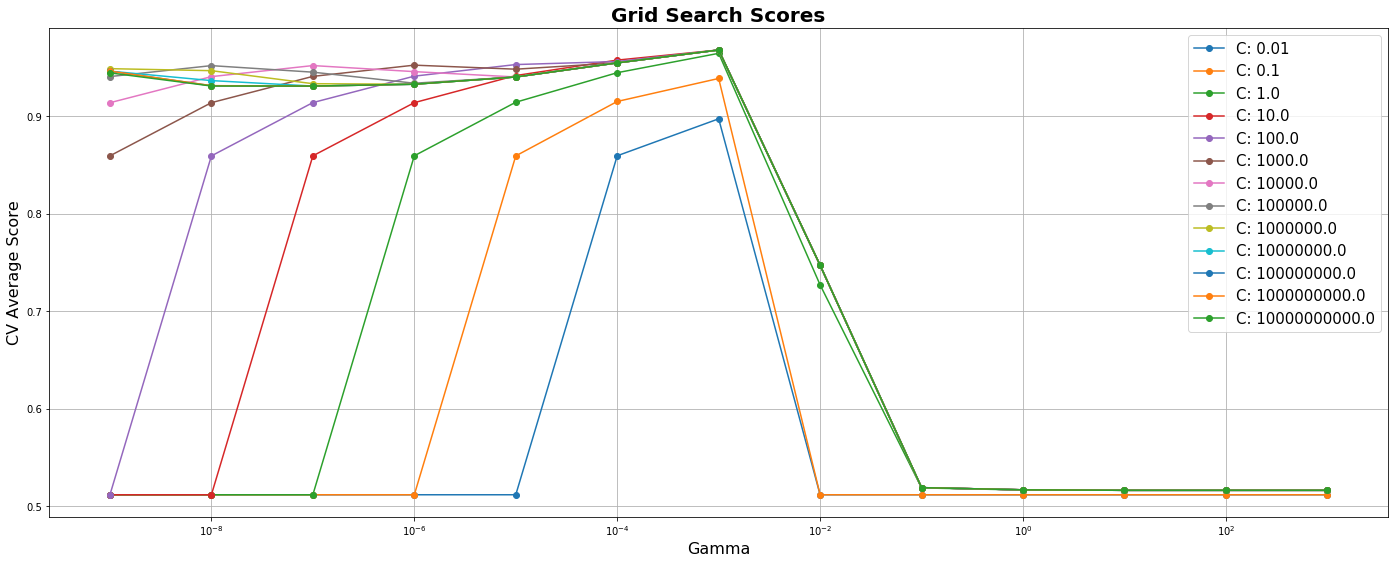

In [13]:
plot_grid_search(top_model.cv_results_,gamma_range,C_range,'Gamma','C')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


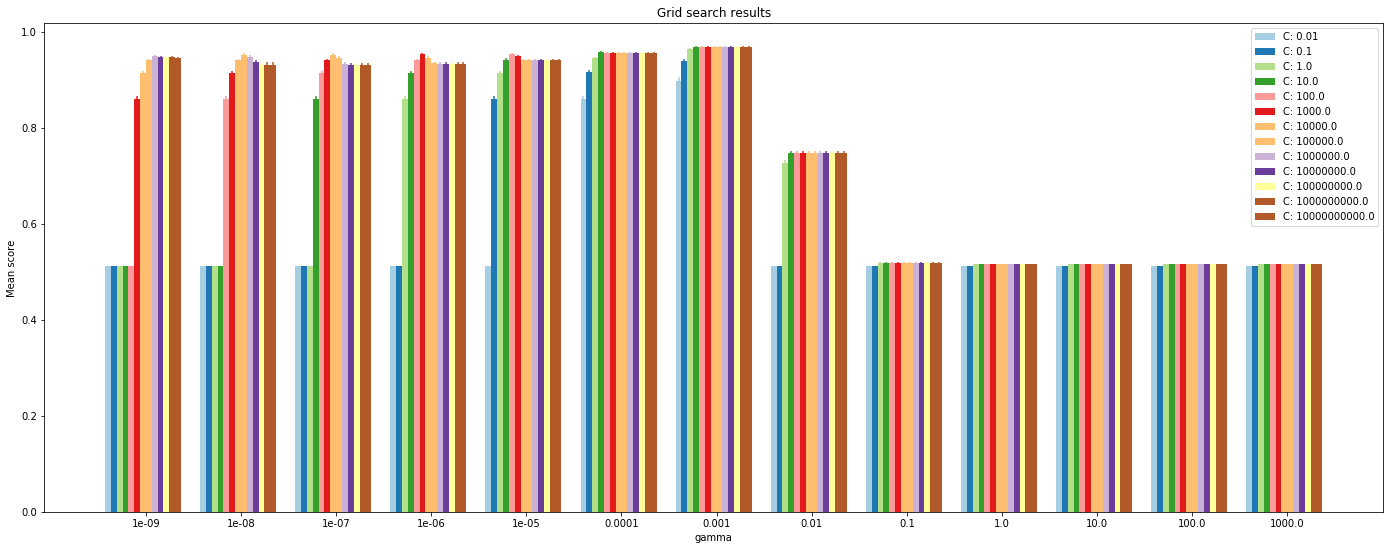

In [14]:
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


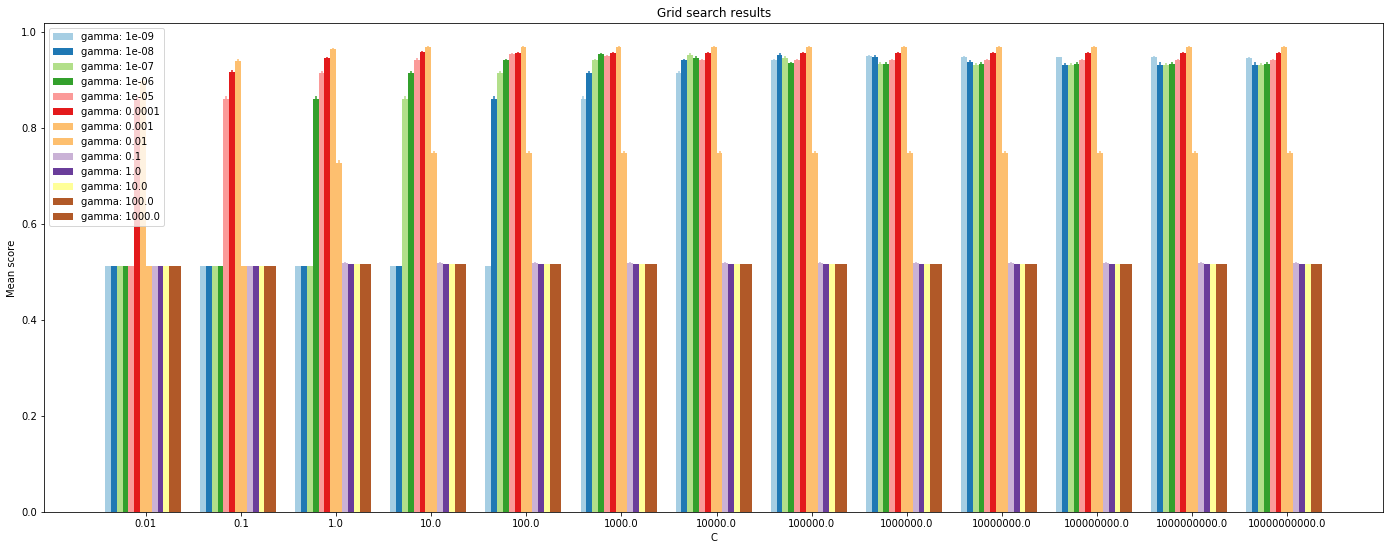

In [15]:
skplot.grid_search(top_model.grid_scores_, change='C', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

In [16]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.SVC(C=top_model.best_params_['C'],gamma=top_model.best_params_['gamma'])
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

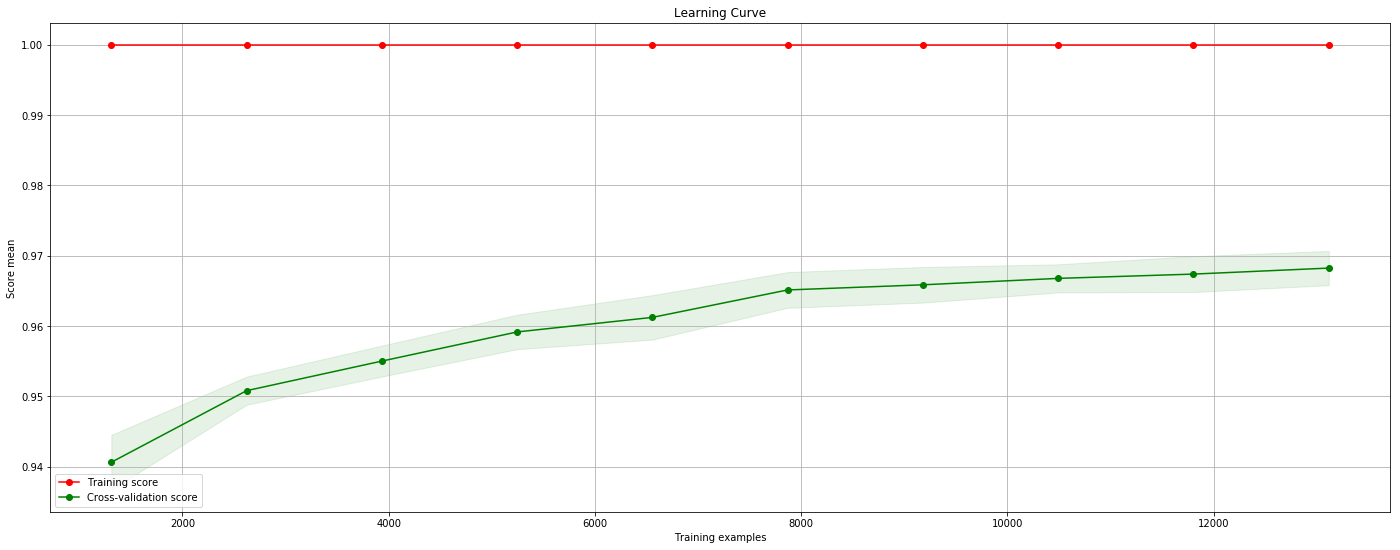

In [17]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()